In [1]:
#from lppy import locproj
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm


In [2]:
#This defines a simple local projection function in python
#Dependencies
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

"""
DEFINE: locproj() => a function to estimate local projects as in Jorda 2005
-----------------------INPUTS -------------------------------
X: matrix containig the shock of interest +  controls
Y: response variable of interest (must be a single vector)
innov_idx: column index of the shock vector in X (indexes start at zero)
horizon: the # of periods you want to know the response for
sig_level: add as an # in (00,100): ex. 90 => function will output 90% confidence interval

------------------------OUTPUTS -----------------------------
irf: the dataframe of resulting response, confidence interval, and horizon
info_store: DF containing series info (units, titles, notes, etc.)
"""

def locproj(X,Y,innov_idx,horizon,sig_level):
    
    #Create an empty array to store results
    irf = np.empty([horizon+1,4])
 
    if Y.ndim > 1:
        raise Exception("INPUT ERROR: Y must be a single column vector")

    if not 0 < sig_level < 100:
        raise Exception("INPUT ERROR: significance level not in range 1 - 100")
    
    #loop from 0 to h periods ahead
    for h in range(0,horizon+1):
        X = sm.add_constant(X)
        #At each point, shift the Y matrix forward, while trimming X to keep them the same length
        X_reg = X[0:len(X)-h,:]
        Y_reg = Y[h:]
        model = sm.OLS(Y_reg, X_reg).fit()
        
        #Return the level for the confidence bands 
        sig_level_se = norm.ppf(1-((100-sig_level)/200))
        #store results in row h
        irf[h,0] = h
        irf[h,1] = model.params[innov_idx+1]
        
        #Create confidence interval bands
        irf[h,2] = irf[h,1]+(model.HC0_se[innov_idx+1]*(-1*sig_level_se))
        irf[h,3] = irf[h,1]+(model.HC0_se[innov_idx+1]*sig_level_se)
    
    #Collect resul matrix into a dataframe
    irf_df = pd.DataFrame(irf, columns = ['horizon','resp','se_low','se_high'])
    return irf_df



             

In [19]:
import colorsys
test = plt.cm.jet(200)
print(test)

(1.0, 0.46550472040668145, 0.0, 1.0)


row is 1 col is: -1
order: [4] and [1]
failed this loop
row is 1 col is: -1
order: [1] and [3]
[-0.06521123  0.77497782  0.58134975 -0.63294366 -0.19610898  0.21462232
  0.29334066 -0.00939702 -0.36651476  0.1506652  -0.09833467]
[-0.13456056  0.54668148  0.59725044 -0.23552903 -0.44980961  0.00783687
  0.41235243  0.13503499 -0.25243417 -0.05499455 -0.05163193]
[ 0.01782937  0.78035214  0.45511481 -0.33409783 -0.55983063  0.32275898
  0.33416863 -0.13538056 -0.17185643  0.02046073  0.09230871]
[ 6.49564496e-04  7.73989775e-01  4.26555534e-01 -2.84520505e-01
 -5.64612304e-01  2.66652060e-01  3.60845173e-01 -8.67563390e-02
 -2.19567216e-01  1.53914365e-02  1.06746555e-01]
[-0.00229135  0.77862377  0.38901477 -0.27704925 -0.5294796   0.26378283
  0.3501032  -0.10970273 -0.24679607  0.04996368  0.10626502]
row is 1 col is: -1
order: [2] and [0]
failed this loop
row is 1 col is: -1
order: [3] and [3]
[-0.34439209  0.81931935  0.131349   -0.00598217 -0.73654056  0.62860209
 -0.05177756 -0.0

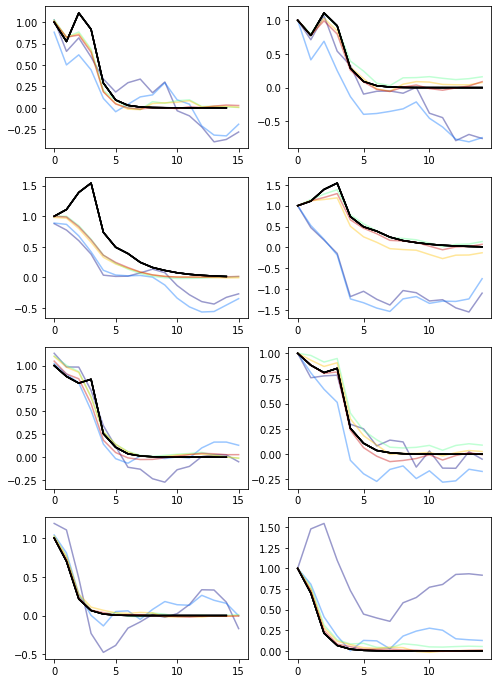

In [27]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

#Goals for the unknown parameters
#take lists of vector length, 1 and 0 etc
#with vector length in hand, its time to generate the DGP
#After this point you can simulate the data and then you need something to compare it to 

#shows the estimate for different numbers of samples

from statsmodels.tsa.ar_model import *
import seaborn as sns 
#sns.set()
fig, axs = plt.subplots(4,2)
plt.rcParams['figure.figsize'] = [8, 12]
# fig.rcParams["figure.autolayout"] = True

i = 0
col_idx = -1
row_idx = 1

while i < 4:
    try:

        print(f"row is {row_idx} col is: {col_idx}")
        rng = np.random.default_rng()
        p = rng.integers(low=0, high=5, size=1)
        q = rng.integers(low=0, high=5, size=1)
        print(f"order: {p} and {q}")
        
        arparams = np.random.rand(p[0],1)
        maparams = np.random.rand(q[0],1)
        
        ar = np.r_[1, -arparams[:,0]] # add zero-lag and negate
        ma = np.r_[1, maparams[:,0]] # add zero-lag
        arma_process = sm.tsa.ArmaProcess(ar, ma)
        
        y = arma_process.generate_sample(10000)
        model = sm.tsa.ARIMA(y,exog=None, order= (p, 0, q), trend='n').fit()

        #Need to find the structural shock
        residual = y - model.fittedvalues

        
        ss_vec = (50,100,1000,2000,10000)
        color_idx =0
        for ss in ss_vec:
            
            LP_color_vec = ('#FFA591','#FF9360','#FC9234','#FE9B16')
            AR_color_vec = ('#85BDFE','#648CFC','#3B4BFB','#2A23F4')
            
            
            armodel = AutoReg(y[0:ss],lags=10).fit()
            print(armodel.params)
            ar_fcast = np.zeros(15)
            last_vals = np.zeros(10)
            last_vals[0] = 1
            ar_fcast[0] =1
            for tstep in range(1,15):
                resp = sum(armodel.params * [1, *last_vals])
                ar_fcast[tstep] = resp
                last_vals[1:10] = last_vals[0:9] 
                last_vals[0] = resp
                
                
            #ar_fcast = armodel.predict(ss,ss+15)
            
            irf = locproj(residual[0:ss],y[0:ss],0,15,99)
            
            #Define plots here 
            axs[i,0].plot(irf.resp,label='LP',color = plt.cm.jet(60*color_idx),alpha = .4)
            axs[i,1].plot(ar_fcast,label='AR',color = plt.cm.jet(60*color_idx),alpha = .4)
            axs[i,0].plot(arma_process.impulse_response(15),color='black',label='ACTUAL')
            axs[i,1].plot(arma_process.impulse_response(15),color='black',label='ACTUAL')
            color_idx += 1
        
        
        # axs[i,0].legend(loc='upper center')
        # axs[i,1].legend(loc='upper center')
        i +=1
    except:
        print("failed this loop")


    


[ 0.74268974 -0.24705517  0.63742852  0.35323164  0.9889322 ]


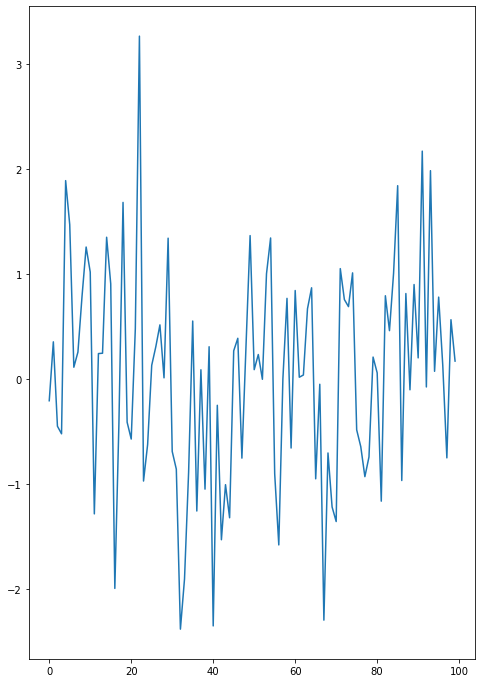

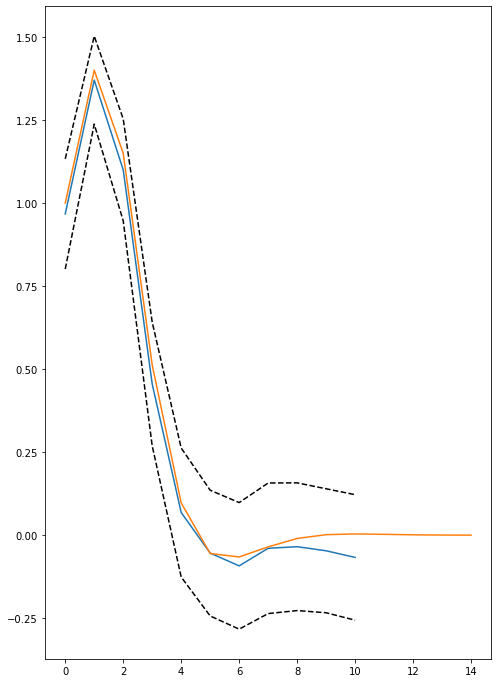

In [4]:
import statsmodels.api as sm
import numpy as np
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)

start_guess = np.r_[arparams, maparams]
y = arma_process.generate_sample(8000)
model = sm.tsa.ARIMA(y,exog=None, order= (2, 0, 2), trend='n').fit()
# model = sm.tsa.ARIMA(y,exog=None, order= (2, 0, 2), trend='n').fit(start_params=start_guess)

print(model.params)
residual =y - model.fittedvalues
plt.plot(residual[0:100])
plt.figure()

irf = locproj(residual[0:800],y[0:800],0,10,99)
plt.plot(irf.resp)
plt.plot(arma_process.impulse_response(15))
plt.plot(irf.se_low,'k--')
plt.plot(irf.se_high,'k--')



In [5]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

AR1_lag1 = np.roll(AR1, -1)
model = sm.OLS(AR1[1:100],AR1_lag1[1:100])
results = model.fit()
results.summary()
beta = results.params[0]
plt.figure()

resp = np.power(alpha, irf.horizon)
estimate = np.power(beta, irf.horizon)
plt.plot(resp,label="actual") 
plt.plot(estimate,label="estimate")
plt.title("Local projection vs Actual")  

NameError: name 'AR1' is not defined

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

#Goals for the unknown parameters
#take lists of vector length, 1 and 0 etc
#with vector length in hand, its time to generate the DGP
#After this point you can simulate the data and then you need something to compare it to 

#shows the estimate for different numbers of samples

from statsmodels.tsa.ar_model import *
import seaborn as sns 
sns.set()
fig, axs = plt.subplots(4,2)
plt.rcParams['figure.figsize'] = [8, 12]
# fig.rcParams["figure.autolayout"] = True

i = 0 
col_idx = -1
row_idx = 1

while i < 8:
    try:

            
        print(f"row is {row_idx} col is: {col_idx}")
        rng = np.random.default_rng()
        p = rng.integers(low=0, high=5, size=1)
        q = rng.integers(low=0, high=5, size=1)
        print(f"order: {p} and {q}")
        
        arparams = np.random.rand(p[0],1)
        maparams = np.random.rand(q[0],1)
        
        ar = np.r_[1, -arparams[:,0]] # add zero-lag and negate
        ma = np.r_[1, maparams[:,0]] # add zero-lag
        arma_process = sm.tsa.ArmaProcess(ar, ma)
        
        y = arma_process.generate_sample(10000)
        model = sm.tsa.ARIMA(y,exog=None, order= (p, 0, q), trend='n').fit()

        #Need to find the structural shock
        residual = y - model.fittedvalues

        ss = 500

        armodel = AutoReg(y[0:ss],lags=10).fit()
        ar_fcast = armodel.predict(ss,ss+15)
        
        irf = locproj(residual[0:ss],y[0:ss],0,15,99)
        i +=1
        col_idx +=1
        
        if i % 2 ==0:
            row_idx +=1
            col_idx =0
            
        if row_idx == 4:
            row_idx = 0
            
        axs[row_idx,col_idx].plot(irf.resp,label='LP')
        axs[row_idx,col_idx].plot(ar_fcast,label='AR')
        axs[row_idx,col_idx].plot(arma_process.impulse_response(15),label='ACTUAL')
        axs[row_idx,col_idx].legend(loc='upper center')
        
    except:
        print("failed this loop")


        




